In [96]:
"""
Based off of:

https://github.com/jamesmcinerney/vi_ibp/
"""
import numpy as np
import random
from scipy.special import psi, gamma
import sys
import os
import time

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

np.random.seed(123)

In [97]:
def generate_synthetic_data(N, K, d1, d2):
    """
    Generates synthetic dataset of images with a fixed basis
    
    X = Zs
    X \in NxD
    Z \in NxK
    s \in KxD
    
    D = d1xd2
    
    Args:
        N: number of points in the data set
        K: number of underlying features
        d1: length of first dimension
        d2: length of second dimension
        
    Returns:
        s: array K x D dictionary of features
        X: synthetically generated dataset
        
    """
    D = d1*d2
    
    #define some shapes
    s = np.zeros((K,D))

    assert K == 8, "we have 8 dims for K"

    s[0,:] = np.array([[0,0,1,0],
                       [1,1,1,1],
                       [0,0,1,0],
                       [0,0,0,0]]).flatten()
    s[1,:] = np.array([[0,1,0,0],
                       [0,1,0,0],
                       [0,1,0,0],
                       [0,1,0,0]]).flatten()
    s[2,:] = np.array([[1,1,1,1],
                       [0,0,0,0],
                       [0,0,0,0],
                       [0,0,0,0]]).flatten()
    s[3,:] = np.array([[1,0,0,0],
                       [0,1,0,0],
                       [0,0,1,0],
                       [0,0,0,1]]).flatten()
    s[4,:] = np.array([[0,0,0,0],
                       [0,0,0,0],
                       [1,1,0,0],
                       [1,1,0,0]]).flatten()
    s[5,:] = np.array([[1,1,1,1],
                       [1,0,0,1],
                       [1,0,0,1],
                       [1,1,1,1]]).flatten()
    s[6,:] = np.array([[0,0,0,0],
                       [0,1,1,0],
                       [0,1,1,0],
                       [0,0,0,0]]).flatten()
    s[7,:] = np.array([[0,0,0,1],
                       [0,0,0,1],
                       [0,0,0,1],
                       [0,0,0,1]]).flatten()

    pr_z = 0.3
    w = np.random.uniform(0.5, 1.0, K) # weight of features
    mut = w[:,np.newaxis]*s
    z = np.random.binomial(1, pr_z, (N, K)) # each feature occurs with prob 0.3 independently 
    X = np.dot(z,mut) + np.random.randn(N, D)*0.1 

    return s, X

In [98]:
def plot_grid(X, d1, d2, final=0, title='', order='C'):
    #takes a NxD matrix and plots N d1xd2 images (where d1xd2==D)
    (N,D) = np.shape(X)
    n1 = int(np.sqrt(N))+1
    fig, ax = plt.subplots(n1, n1)
    n = 0
    for i in range(n1):
        for j in range(n1):
            if n >= N: break
            imgplot = ax[i,j].imshow(np.reshape(X[n,:], (d1,d2), order=order).T,
                                     cmap=cm.Greys_r) #, vmin=0, vmax=2)
            imgplot.set_interpolation('nearest')
            n += 1 
    fig.suptitle(title)
    fig.show()

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


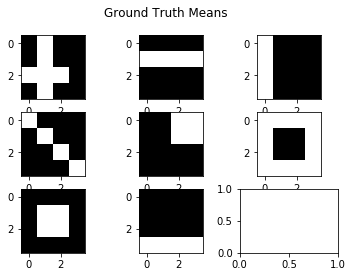

In [99]:
################################
## Generate synthetic dataset ##
################################
N = 500
d1, d2 = 4, 4
D = d1*d2
K = 8
dictionary, X = generate_synthetic_data(N, K, d1, d2)
plot_grid(dictionary, d1, d2, title='Ground Truth Means')

In [100]:
X.shape

(500, 16)

In [150]:
#######################
## Model Hyperparams ##
#######################
K = 15
sigma_A = 0.1
sigma_n = 0.1
#alpha = 0.7
alphas = [0.2, 0.4, 0.6, 0.8, 1.0]


#############################
## Optimization parameters ##
#############################
rounds = 500
#elbos = []
elbos = {alpha: [] for alpha in alphas}

############################
## Variational parameters ##
############################
Phi = 0.1 * np.ones((D, D, K))
phi = np.random.uniform(0, 1, (K, D))
tau = np.random.uniform(0, 1, (K, 2))
nu = np.random.uniform(0, 1, (N, K))
nu = nu/np.sum(nu, axis=1).reshape((-1,1)) # want contributions from features space to sum to 1

In [165]:
def elbo(phi, Phi, nu, tau):
    """ELBO calculation
    Args:
        Variational params
    Return:
        loss - scalar
    """
    # equation 6 from Doshi
    
    tmp1 = K*np.log(alpha / K) + np.sum(((alpha/K) -1)*(psi(tau[:, 0]) - psi(tau[:, 0] + tau[:, 1])))
    #print("tmp1: {}".format(tmp1))
        
    tmp2 = np.sum(nu * psi(tau[:, 0]) + (1-nu)*psi(tau[:, 1]) - psi(tau[:, 0] + tau[:, 1]))
    #print("tmp2: {}".format(tmp2))
    ################
    
    tmp3 = -0.5 * D * K * np.log(2*np.pi*(sigma_A**2))
    for k in range(K):
        tmp3 += -0.5*(1.0/(sigma_A**2))*(np.trace(Phi[:, :, k]) + np.dot(phi[k, :], phi[k, :]))
    #print("tmp3: {}".format(tmp3))
    ##################
    
    tmp4 = -0.5*D*N*np.log(2*np.pi*(sigma_n**2))
    for n in range(N):
        tmp4 += -0.5*(1.0/(sigma_n**2)) * np.dot(X[n,:], X[n,:])
    
    for n in range(N):
        for k in range(K):
            tmp4 += (1.0/(sigma_n**2)) * (nu[n, k] * np.dot(phi[k, :], X[n, :]))
            
    for n in range(N):
        for _k in range(K):
            for k in range(_k):
                tmp4 += -(1.0/(sigma_n**2))*(nu[n, k]*nu[n, _k]*np.dot(phi[k, :], phi[_k, :]))
    
    for k in range(K):
        tmp4 += -0.5*(1.0/(sigma_n**2))*np.sum(nu[:,k]*(np.trace(Phi[:,:,k]) + np.dot(phi[k, :], phi[k, :])))
    #print("tmp4: {}".format(tmp4))
    ##################
    
    tmp5 = np.sum(np.log((gamma(tau[:, 0])*gamma(tau[:, 1])) / gamma(tau[:, 0] + tau[:, 1])) -\
                  (tau[:, 0] - 1)*psi(tau[:, 0]) - (tau[:, 1] -1)*psi(tau[:, 1]) +\
                  (tau[:, 0] + tau[:,1] - 2)*psi(tau[:, 0] + tau[:, 1]))
    #print("tmp5: {}".format(tmp5))
    epsilon = 1e-8
    tmp6 = np.sum(-nu*np.log(nu+epsilon) - (1 - nu)*np.log(1-nu+epsilon))
    #print(tmp6)
    #print(nu)
    for k in range(K):
        tmp6 += 0.5*np.log(((2*np.pi*np.exp(1.0))**D)*np.linalg.det(Phi[:, :, k]))
    #print("tmp6: {}".format(tmp6))
    return tmp1+tmp2+tmp3+tmp4+tmp5+tmp6

In [166]:
alphas = [0.2, 0.4, 0.6, 0.8, 1.0]
for alpha in alphas:
    ############################
    ## Variational parameters ##
    ############################
    Phi = 0.1 * np.ones((D, D, K))
    phi = np.random.uniform(0, 1, (K, D))
    tau = np.random.uniform(0, 1, (K, 2))
    nu = np.random.uniform(0, 1, (N, K))
    nu = nu/np.sum(nu, axis=1).reshape((-1,1)) # want contributions from features space to sum to 1
    print("alpha: {}".format(alpha))
    for t in range(rounds):
        if t % 100 == 0:
            print("Iter: {}".format(t))

        A = np.zeros((N, K))
        P = X - np.dot(nu, phi) # N x D
        v = np.zeros((N, K))
        for k in range(K):
            # eqn on p 28 of Doshi
            # for all n and k!
            A[:, k] = np.dot(phi[k, :], # D
                             np.transpose(P + np.outer(nu[:, k], phi[k, :]))
                             ) # D x (N x D) = N

            v[:, k] = psi(tau[k, 0]) + psi(tau[k, 1]) -\
                        (0.5/(sigma_n**2))*(np.trace(Phi[:,:,k]) +\
                        np.dot(phi[k, :], phi[k, :])) + (1/(sigma_n**2))*A[:,k]

            nu[:, k] = 1.0 / (1.0 + np.exp(-v[:, k]))    
        # Update the variational parameters for the Gaussian dictionary    
        # eqn on page 27 of Doshi 
        # for all k
        for k in range(K):
            Phi[:, :, k]    = (1.0/(1/sigma_A**2 + (1/sigma_n**2) * np.sum(nu[:,k]))) * np.identity(D)
            phi[k, :]       = (1/sigma_n**2) * \
                               np.dot(nu[:, k].T, X - np.dot(nu, phi) + np.outer(nu[:, k], phi[k, :])) *\
                               Phi[0, 0, k]

        # Update variational Beta parameters
        # eqn on page 28 of Doshi
        nu_sum = np.sum(nu, axis=0)
        tau_tmp[:, 0] = alpha/K + nu_sum
        tau_tmp[:, 1] = N + 1 - nu_sum
        if t % 10 == 0:
            elbos[alpha].append(elbo(phi, Phi, nu, tau))

alpha: 0.2
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
alpha: 0.4
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
alpha: 0.6
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
alpha: 0.8
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
alpha: 1.0
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400


/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


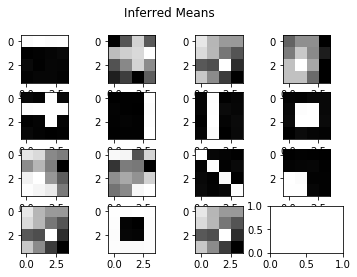

In [167]:
# The means of the Gaussian dictionary should contain the 
plot_grid(phi, d1, d2, title='Inferred Means', order='F')

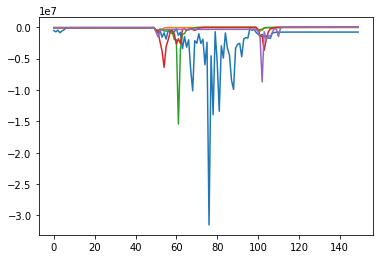

In [168]:
for alpha in alphas:
    plt.plot(elbos[alpha])
    #plt.yscale('log')
plt.show()
# :(